Generate bare CIM Hamiltonian and collect the DMRG ground states 

In [6]:
using ITensors, ITensorMPS, Optim, LinearAlgebra, Printf, Random, Plots, DelimitedFiles, JLD2
include("src/basic_CPHL_utils.jl")
include("src/CPHL_module.jl")
include("src/basic_MPS_utils.jl")
include("src/QuantumResource1D.jl")
include("src/HL_module.jl")
include("src/basic_MPS_utils.jl")

N_g = 50;
g_vals = collect(range(-1, 1; length = N_g + 2)[2:end-1]);
N_sites = 5;
cphl = CPHL.CPHLSolver(N_sites, g_vals);
CPHL.SetUpHamiltonians(cphl);
CPHL.SetUpHamiltonians(cphl);
CPHL.SetUpHamiltonians(cphl);

OString_bare_vals = copy(cphl.OString_GS_vals);
ZZ_bare_vals = copy(cphl.ZZ_GS_vals);

Ladder circuit simulation, optimize overlaps with the bare GSs of the CIM

Fidelity wrt to GHZ = 1.0
Fidelity wrt to cluster state = 1.0

=== g = -0.9607843137254902 ===

=== ind_g = 1 ===


┌ Warning: Calling `inner(x::MPS, A::MPO, y::MPS)` where the site indices of the `MPS`
│ `x` and the `MPS` resulting from contracting `MPO` `A` with `MPS` `y` don't
│ match is deprecated as of ITensors v0.3 and will result in an error in ITensors
│ v0.4. The most common cause of this is something like the following:
│ 
│ ```julia
│ s = siteinds("S=1/2")
│ psi = random_mps(s)
│ H = MPO(s, "Id")
│ inner(psi, H, psi)
│ ```
│ 
│ `psi` has the Index structure `-s-(psi)` and `H` has the Index structure
│ `-s'-(H)-s-`, so the Index structure of would be `(dag(psi)-s- -s'-(H)-s-(psi)`
│  unless the prime levels were fixed. Previously we tried fixing the prime level
│   in situations like this, but we will no longer be doing that going forward.
│ 
│ There are a few ways to fix this. You can simply change:
│ 
│ ```julia
│ inner(psi, H, psi)
│ ```
│ 
│ to:
│ 
│ ```julia
│ inner(psi', H, psi)
│ ```
│ 
│ in which case the Index structure will be `(dag(psi)-s'-(H)-s-(psi)`.
│ 
│ Alternatively, you c

Candidate fidelity: 0.2277960233899805
Candidate fidelity: 0.2277960233899805
Candidate fidelity: 0.9999999996249659
Candidate fidelity: 0.9999999996249644
Candidate fidelity: 0.9999999996249649
Fidelity with GS: 0.9999999996249659

=== g = -0.9215686274509803 ===

=== ind_g = 2 ===
Candidate fidelity: 0.9999999934923955
Candidate fidelity: 0.23102391598348573
Candidate fidelity: 0.9999999934923959
Candidate fidelity: 0.9999999934923964
Candidate fidelity: 0.9999999934923964
Fidelity with GS: 0.9999999934923964

=== g = -0.8823529411764706 ===

=== ind_g = 3 ===
Candidate fidelity: 0.9999999642035745
Candidate fidelity: 0.23449687916603315
Candidate fidelity: 0.999999964203575
Candidate fidelity: 0.9999999642035746
Candidate fidelity: 0.999999964203575
Fidelity with GS: 0.999999964203575

=== g = -0.8431372549019608 ===

=== ind_g = 4 ===
Candidate fidelity: 0.9999998759349509
Candidate fidelity: 0.23824987135955716
Candidate fidelity: 0.9999998759349511
Candidate fidelity: 0.999999875

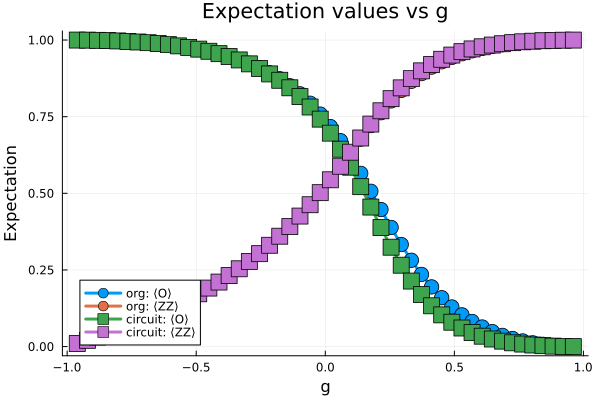

In [ ]:
sites = siteinds("S=1/2", N_sites)
X_string_mpo = generate_X_string_mpo(sites)
O_string_mpo = generate_O_string_mpo(sites)
ZZ_term_mpo = generate_ZZ_term_mpo(sites)
qr = QR1D.QuantumResource1D(N_sites, sites, X_string_mpo, O_string_mpo, ZZ_term_mpo)
GHZ_wf, params_GHZ, name_GHZ = QR1D.generate_GHZ_state(qr)
cluster_wf, params_cluster, name_cluster = QR1D.generate_cluster_state(qr)

all_params = []
all_X_exp, all_O_exp, all_ZZ_exp = [], [], []
fidelity_with_GS = []

all_params_mat = readdlm("DATA/circuit_all_params_mat_$(5)_bare.txt")

θ_prev = params_GHZ

for (ind_g, g) in enumerate(g_vals)
    println("\n=== g = $g ===")
    println("\n=== ind_g = $ind_g ===")

    qr_g = QR1D.QuantumResource1D(N_sites, sites, X_string_mpo, O_string_mpo, ZZ_term_mpo);
    QR1D.AddQR(qr_g, GHZ_wf, params_GHZ, name_GHZ);
    QR1D.AddQR(qr_g, cluster_wf, params_cluster, name_cluster);

    ψ_GS_g = cphl.ψ_GS_list[ind_g]
    ψ_GS_g = normalize(ψ_GS_g)

    # candidates = [θ_prev, params_GHZ, params_cluster, 0.1 * randn(length(params_GHZ)), 0.5 * (1 + g) * params_GHZ + 0.5 * (1 - g) * params_cluster] #run it once to generate candidates
    candidates = [θ_prev, all_params_mat[:, ind_g], params_GHZ, params_cluster, 0.1 * randn(length(params_GHZ)), 0.5 * (1 + g) * params_GHZ + 0.5 * (1 - g) * params_cluster]

    best_fidelity = 0.0
    best_θ = nothing
    for θ in candidates
        θ_fin = QR1D.optimize_fidelity(qr_g, ψ_GS_g, θ)
        
        ψ_candidate = QR1D.apply_ladder_circuit(qr_g, θ_fin)
        fidelity = abs2(inner(ψ_candidate, ψ_GS_g))
        println("Candidate fidelity: $fidelity")
        if fidelity > best_fidelity
            best_fidelity = fidelity
            best_θ = copy(θ_fin)
        end
    end
    θ_g = copy(best_θ)
    θ_prev = copy(θ_g)
    
    psi_g = QR1D.apply_ladder_circuit(qr_g, θ_g)
    println("Fidelity with GS: $(abs2(inner(psi_g, ψ_GS_g)))")
    
    X_expval, O_expval, ZZ_term_ev = QR1D.aux_exp_vals(qr_g, psi_g)

    push!(all_params, θ_g)
    push!(all_X_exp, X_expval)
    push!(all_O_exp, O_expval)
    push!(all_ZZ_exp, ZZ_term_ev)
    push!(fidelity_with_GS, abs2(inner(psi_g, ψ_GS_g)))
end

all_params_mat = hcat(all_params...)
writedlm("DATA/circuit_all_params_mat_$(N_sites)_bare.txt", all_params_mat)
writedlm("DATA/circuit_fidelity_with_GS_$(N_sites)_bare.txt", fidelity_with_GS)
writedlm("DATA/circuit_X_exp_$(N_sites)_bare.txt", all_X_exp)
writedlm("DATA/circuit_O_exp_$(N_sites)_bare.txt", all_O_exp)
writedlm("DATA/circuit_ZZ_exp_$(N_sites)_bare.txt", all_ZZ_exp)

p = plot(
    cphl.g_vals, OString_bare_vals,
    label = "org: ⟨O⟩",
    title = "Expectation values vs g",
    xlabel = "g",
    ylabel = "Expectation",
    linewidth = 3,
    marker = (:circle, 8),   # circle markers, size 8
)

plot!(
    p, cphl.g_vals, ZZ_bare_vals ./ (cphl.N_sites - 1),
    label = "org: ⟨ZZ⟩",
    linewidth = 3,
    marker = (:circle, 8),
)

plot!(
    p, cphl.g_vals, all_O_exp,
    label = "circuit: ⟨O⟩",
    linewidth = 3,
    marker = (:square, 8),
)

plot!(
    p, cphl.g_vals, all_ZZ_exp ./ (cphl.N_sites - 1),
    label = "circuit: ⟨ZZ⟩",
    linewidth = 3,
    marker = (:square, 8),
)

display(p)


Ladder circuit simulation, optimize overlaps with the optimized GSs

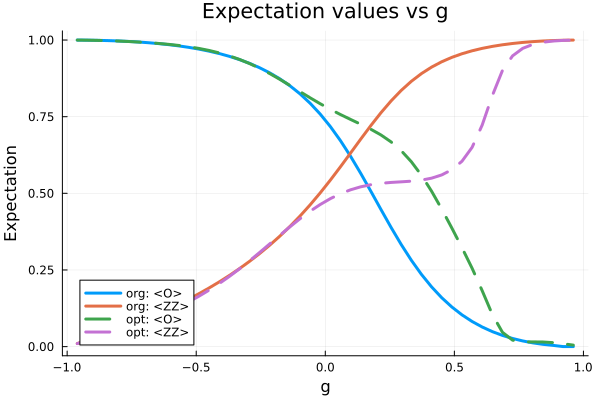

In [ ]:
@load "DATA/ALPHAMat_$(N_sites).jld2" ALPHAMat


all_params_mat = readdlm("DATA/circuit_all_params_mat_$(N_sites)_bare.txt")

cphl.ALPHAMat = ALPHAMat
CPHL.SetUpHamiltonians(cphl);
CPHL.SetUpHamiltonians(cphl);
CPHL.SetUpHamiltonians(cphl);

p = plot(cphl.g_vals, OString_bare_vals, label="org: <O>", title="Expectation values vs g", xlabel="g", ylabel="Expectation", linewidth=3);
plot!(p, cphl.g_vals, ZZ_bare_vals / (cphl.N_sites - 1), label="org: <ZZ>", linewidth=3);

plot!(p, cphl.g_vals, cphl.OString_GS_vals, label="opt: <O>", title="Expectation values vs g", xlabel="g", ylabel="Expectation", linewidth=3, linestyle = :dash);
plot!(p, cphl.g_vals, cphl.ZZ_GS_vals / (cphl.N_sites - 1), label="opt: <ZZ>", linewidth=3, linestyle = :dash);
display(p)

Fidelity wrt to GHZ = 1.0
Fidelity wrt to cluster state = 1.0

=== g = -0.9607843137254902 ===

=== ind_g = 1 ===
Candidate fidelity: 0.999994325208488
Fidelity with GS: 0.999994325208488

=== g = -0.9215686274509803 ===

=== ind_g = 2 ===
Candidate fidelity: 0.9999778423352019
Fidelity with GS: 0.9999778423352019

=== g = -0.8823529411764706 ===

=== ind_g = 3 ===
Candidate fidelity: 0.9999526417246385
Fidelity with GS: 0.9999526417246385

=== g = -0.8431372549019608 ===

=== ind_g = 4 ===
Candidate fidelity: 0.9999223012845014
Fidelity with GS: 0.9999223012845014

=== g = -0.803921568627451 ===

=== ind_g = 5 ===
Candidate fidelity: 0.9998914299353354
Fidelity with GS: 0.9998914299353354

=== g = -0.7647058823529411 ===

=== ind_g = 6 ===
Candidate fidelity: 0.9998650344723132
Fidelity with GS: 0.9998650344723132

=== g = -0.7254901960784313 ===

=== ind_g = 7 ===
Candidate fidelity: 0.9998477794518145
Fidelity with GS: 0.9998477794518145

=== g = -0.6862745098039216 ===

=== ind_g =

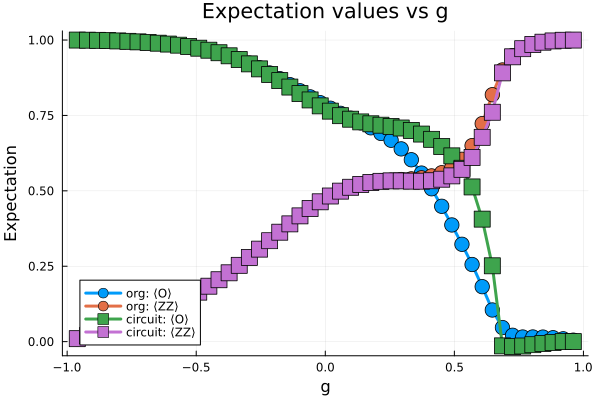

In [ ]:
sites = siteinds("S=1/2", N_sites)
X_string_mpo = generate_X_string_mpo(sites)
O_string_mpo = generate_O_string_mpo(sites)
ZZ_term_mpo = generate_ZZ_term_mpo(sites)
qr = QR1D.QuantumResource1D(N_sites, sites, X_string_mpo, O_string_mpo, ZZ_term_mpo)
GHZ_wf, params_GHZ, name_GHZ = QR1D.generate_GHZ_state(qr)
cluster_wf, params_cluster, name_cluster = QR1D.generate_cluster_state(qr)

all_params = []
all_X_exp, all_O_exp, all_ZZ_exp = [], [], []
fidelity_with_GS = []

θ_prev = params_GHZ
for (ind_g, g) in enumerate(g_vals)
    println("\n=== g = $g ===")
    println("\n=== ind_g = $ind_g ===")

    qr_g = QR1D.QuantumResource1D(N_sites, sites, X_string_mpo, O_string_mpo, ZZ_term_mpo);
    QR1D.AddQR(qr_g, GHZ_wf, params_GHZ, name_GHZ);
    QR1D.AddQR(qr_g, cluster_wf, params_cluster, name_cluster);

    ψ_GS_g = cphl.ψ_GS_list[ind_g]
    ψ_GS_g = normalize(ψ_GS_g)

    candidates = [θ_prev, all_params_mat[:, ind_g], params_GHZ, params_cluster, 0.1 * randn(length(params_GHZ)), 0.5 * (1 + g) * params_GHZ + 0.5 * (1 - g) * params_cluster]

    best_fidelity = 0.0
    best_θ = nothing
    for θ in candidates
        θ_fin = QR1D.optimize_fidelity(qr_g, ψ_GS_g, θ)
        
        ψ_candidate = QR1D.apply_ladder_circuit(qr_g, θ_fin)
        fidelity = abs2(inner(ψ_candidate, ψ_GS_g))
        println("Candidate fidelity: $fidelity")
        if fidelity > best_fidelity
            best_fidelity = fidelity
            best_θ = copy(θ_fin)
        end
    end
    θ_g = copy(best_θ)
    θ_prev = copy(θ_g)
    
    psi_g = QR1D.apply_ladder_circuit(qr_g, θ_g)
    println("Fidelity with GS: $(abs2(inner(psi_g, ψ_GS_g)))")
    
    X_expval, O_expval, ZZ_term_ev = QR1D.aux_exp_vals(qr_g, psi_g)

    push!(all_params, θ_g)
    push!(all_X_exp, X_expval)
    push!(all_O_exp, O_expval)
    push!(all_ZZ_exp, ZZ_term_ev)
    push!(fidelity_with_GS, abs2(inner(psi_g, ψ_GS_g)))
end

all_params_mat = hcat(all_params...)
writedlm("DATA/circuit_all_params_mat_$(N_sites)_opt.txt", all_params_mat)
writedlm("DATA/circuit_fidelity_with_GS_$(N_sites)_opt.txt", fidelity_with_GS)
writedlm("DATA/circuit_X_exp_$(N_sites)_opt.txt", all_X_exp)
writedlm("DATA/circuit_O_exp_$(N_sites)_opt.txt", all_O_exp)
writedlm("DATA/circuit_ZZ_exp_$(N_sites)_opt.txt", all_ZZ_exp)

p = plot(
    cphl.g_vals, cphl.OString_GS_vals,
    label = "org: ⟨O⟩",
    title = "Expectation values vs g",
    xlabel = "g",
    ylabel = "Expectation",
    linewidth = 3,
    marker = (:circle, 8),   # circle markers, size 8
)

plot!(
    p, cphl.g_vals, cphl.ZZ_GS_vals ./ (cphl.N_sites - 1),
    label = "org: ⟨ZZ⟩",
    linewidth = 3,
    marker = (:circle, 8),
)

plot!(
    p, cphl.g_vals, all_O_exp,
    label = "circuit: ⟨O⟩",
    linewidth = 3,
    marker = (:square, 8),
)

plot!(
    p, cphl.g_vals, all_ZZ_exp ./ (cphl.N_sites - 1),
    label = "circuit: ⟨ZZ⟩",
    linewidth = 3,
    marker = (:square, 8),
)

display(p)
